# **CA6 - Clustering**

# Elahe Khodaverdi - 810100132

In this project, we intend to solve the classification problem of data collected from Asre Iran news agency using different unsupervised clustering algorithms.

Initially, we preprocess our data. Then, we use the KMeans and DBSCAN algorithms to solve the problem. After that, we evaluate our models using the homogeneity criterion and silhouette score. For preprocessing the data, since our data was in Persian, we used the `hazm` library.

At the beginning of our code, we import the necessary libraries and load our data.

In [1]:
from hazm import *
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import multiprocessing
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import homogeneity_score, silhouette_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df

,label,content
0,فناوری,گزارش های منتشر شده حاکی از آن است که کاربران ...
1,ورزشی,سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2,حوادث,مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3,فناوری,یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4,سلامت,دانشمندان در جدیدترین مطالعات خود اثرات جدید و...
...,...,...
8995,حوادث,شانزدهم مهر امسال درپی تماس با مرکز فوریت‌های ...
8996,ورزشی,اتحادیه فوتبال ترینیداد و توباگو اعلام کرده تی...
8997,فرهنگی/هنری,اسامی 18 فیلم بخش مسابقه مستند ششمین دوره جشنو...
8998,حوادث,کامیونت حامل بار تخته‌های چوبی عصر دیروز چهارش...


In [4]:
train_df.describe()

,label,content
count,9000,9000
unique,6,8980
top,فناوری,منبع: ایسنا
freq,1500,4


In [5]:
train_df['label'].value_counts()

label
فناوری         1500
ورزشی          1500
حوادث          1500
سلامت          1500
سیاسی          1500
فرهنگی/هنری    1500
Name: count, dtype: int64

In [6]:
test_df['label'].value_counts()

label
حوادث          200
سیاسی          200
ورزشی          190
فرهنگی/هنری    180
سلامت          177
فناوری         168
Name: count, dtype: int64

1. **Imbalanced data challenges in clustering process and strategies**
- Challenges: 
    - **Bias towards Majority Class**: Clustering algorithms may be biased towards the majority class, leading to clusters that predominantly represent the majority class. This can result in poor representation of minority classes.

    - **Difficulty in Identifying Minority Clusters**: Minority classes may be treated as noise or outliers, making it difficult to identify meaningful clusters within these classes.

    - **Poor Evaluation Metrics**: Traditional evaluation metrics may not accurately reflect the performance of a clustering algorithm on imbalanced data.

- Strategies:
    - **Resampling Techniques**: You can either oversample the minority class or undersample the majority class to achieve a more balanced dataset.

    - **Anomaly Detection**: Treat the minority class as an anomaly and use anomaly detection techniques to identify these instances.

    - **Using Appropriate Evaluation Metrics**: Use evaluation metrics that are less sensitive to class imbalance, such as the Silhouette Coefficient or Dunn Index.

    - **Cost-Sensitive Learning**: Assign higher misclassification costs to the minority class during model training to increase its importance.

    - **Ensemble Methods**: Create multiple subsets of the original data, create a clustering model for each subset, and then combine the results

## **Preprocessing Data**

In [7]:
normalizer = Normalizer()
stemmer = Stemmer()
sw = stopwords_list()
lemmatizer = Lemmatizer()
stemmer = Stemmer()

In [8]:
def preprocess_text(text):
    normalized_text = normalizer.normalize(text)
    punct_normalized = re.sub(r'[^\w\s]', '', normalized_text)
    tokens = word_tokenize(punct_normalized)
    tokens_without_stopwords = [token for token in tokens if token not in sw]
    tokens_without_numbers = [re.sub(r'\d+', '', token) for token in tokens_without_stopwords]
    tokens_root = [lemmatizer.lemmatize(token) for token in tokens_without_numbers]
    non_empty_tokens = [token for token in tokens_root if token.strip() != '']
    return ' '.join(non_empty_tokens)

In [9]:
train_df['content'][0]

'گزارش های منتشر شده حاکی از آن است که کاربران تلگرام در مناطقی از جهان همچون اروپا و خاورمیانه با مشکل مواجه شده اند. به گزارش ایسنا، به نقل از تلگرام، دقایقی پیش پیام رسان تلگرام در صفحه توییتر خود اعلام کرد که دسترسی کاربران این اپلیکیشن در اروپا و خاورمیانه با مشکل مواجه شده است. طبق این پیام، به نظر می رسد که منشا این اختلالات از ظهر امروز، پنج شنبه، خارجی و از سوی خود این پیام رسان بوده است و ارتباطی با داخل کشور ندارد. این پیام رسان در این خصوص عنوان کرده است که متخصصان تلگرام از زمانی که متوجه چنین اختلالی شده اند، در حال بررسی و برطرف کردن مشکل مربوطه بوده و امید است به زودی این اختلال رفع شود و کاربران به حساب های کاربری خود در تلگرام دسترسی یابند.'

In [10]:
train_df['content'] = train_df['content'].apply(preprocess_text)
test_df['content'] = test_df['content'].apply(preprocess_text)

2. **Stemming and Lemmatization**

Stemming and lemmatization are both ways used in language processing to simplify words to their basic form. But they do this in different ways:

- **Stemming**: This is a basic method that cuts off the ends of words hoping to get this right most of the time. It uses a simple approach and works on simplifying words to their stem or root form.
    - The stem of “am”, “are”, “is” might be “am”, “ar”, “is” respectively.

- **Lemmatization**: This is a more advanced method that looks at the structure of the words and correctly identifies the base form for each word. To do this, it needs to have detailed word lists which the method can use to connect the word back to its base form.
    - The lemma of “am”, “are”, “is” is “be”.



## **Problem-solving process**

3. **Feature Vectors**

Feature vectors are used in machine learning to show characteristics, or features, of an object in a way that's easy to understand mathematically. They're important for many areas of machine learning. Here's why we use feature vectors:

- **Numerical Representation**: Machine learning algorithms need a numerical representation of objects to do their work. Feature vectors provide this.

- **Reducing Complexity**: Feature vectors help in making the data simpler by picking the most important features. This not only makes the work less complex but also reduces the risk of overfitting and helps the model’s abilities.

- **Effective Analysis**: Feature vectors are used a lot in machine learning because they're good at showing objects in a numerical way to help with many kinds of analyses. They're good for analysis because there are many ways to compare feature vectors.

As for what feature vectors are like, they are:

- **Numerical or Symbolic**: A feature is a numerical or symbolic property of part of an object.

- **Vector Form**: A feature vector is a vector that contains multiple elements about an object.

- **Representation of Object**: It is a mathematical representation of the features or attributes that describe the object or data point. These features can be anything from numbers, categories, text, images, or even sound.

- **Foundation of Models**: They serve as the base upon which models are built and predictions are made. By capturing the important characteristics of the data, feature vectors enable algorithms to generalize and make accurate predictions on unseen data.

4. **Word2Vec, Doc2Vec, and Vectorization**

- ***Word2Vec***:
 Word2Vec is a two-layer neural network that processes text by “vectorizing” words. Its input is a text corpus and its output is a set of vectors. Word2Vec creates vectors that are distributed numerical representations of word features, features such as the context of individual words. Given enough data, usage, and contexts, Word2Vec can make highly accurate guesses about a word’s meaning based on past appearances. These guesses can be used to establish a word’s association with other words, or cluster documents and classify them by topic.
Word2Vec uses two primary models: Continuous Bag-of-Words model (CBOW) and the Skip-Gram model. CBOW predicts target words from source context words, while the skip-gram does the inverse and predicts source context-words from the target words.

- ***Doc2Vec***: Doc2Vec, also known as Paragraph Vector, is an extension of Word2Vec. It’s designed to create a numeric representation of an entire document, unlike Word2Vec which creates a representation for individual words. It maintains the order of words in a document, which is important for capturing the context and semantics.
Doc2Vec uses two techniques: Distributed Memory (DM) and Distributed Bag of Words (DBOW). DM acts as a memory that remembers what is missing from the current context, while DBOW ignores the context words in the input, but forces the model to predict words randomly sampled from the paragraph in the output.

- ***Vectorization***: Vectorization, the process of converting text into numerical feature vectors, is a crucial step in Natural Language Processing (NLP) and machine learning. It transforms raw text into a numerical format that algorithms can interpret and process. Here are some prevalent techniques for text-to-feature vector conversion:

    - *Bag of Words (BoW)*: This approach views text documents as a bag of words, disregarding grammar and word order but maintaining a frequency record. Each unique word in the text corresponds to one dimension in the vector space, and the value in each dimension could indicate the presence or absence of a word in the text, or it could reflect the word’s frequency.

    - *TF-IDF (Term Frequency-Inverse Document Frequency)*: This statistical measure evaluates a word’s relevance to a document within a document collection. The relevance increases in proportion to the number of times a word appears in the document but is counterbalanced by the word’s frequency in the corpus.

    - *Word Embeddings (like Word2Vec)*: These are a form of word representation that enables words with similar meanings to have similar representations. They can capture a word’s context in a document, its semantic and syntactic similarity, and its relation with other words.


5. **K-mean vs DBSCAN**
- **K-means Clustering**:

K-means is a clustering algorithm that is based on centroids or partitions. It divides all points in the sample space into K groups based on similarity. The algorithm operates as follows

1. K centroids are placed randomly, one for each cluster.
2. The distance of each point from each centroid is computed.
3. Each data point is allocated to the centroid closest to it, forming a cluster.
4. The positions of the K centroids are updated.

- Advantages of K-means:
    - It is efficient for large datasets.
    - It performs well with clusters that have a globular shape.

- Disadvantages of K-means:
    - It is sensitive to the specified number of clusters.
    - It does not perform well with datasets that contain outliers or noise.

- **DBSCAN Clustering**:

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that is based on density. The key principle of this algorithm is that the neighborhood of each point in a cluster, which is within a given radius (R), must contain a minimum number of points (M). The algorithm operates as follows

1. The type of each point is determined. Each data point in our dataset may be one of the following:
    - Core Point: A data point is a core point if there are at least M points in its neighborhood, i.e., within the specified radius (R).
    - Border Point: A data point is classified as a border point if its neighborhood contains fewer than M data points, or it is reachable from some core point, i.e., it is within R-distance from a core point.
    - Outlier Point: An outlier is a point that is not a core point and is also not close enough to be reachable from a core point.
2. The outlier points are removed.
3. Core points that are neighbors are connected and placed in the same cluster.
4. The border points are assigned to each cluster.

- Advantages of DBSCAN:
    - The number of clusters does not need to be specified.
    - It efficiently handles outliers and noisy datasets.
    - It can find clusters of arbitrary shapes.

- Disadvantages of DBSCAN:
    - It cannot efficiently handle high-dimensional datasets.


In [11]:
data = pd.concat([train_df, test_df])

In [12]:
tagged_train = [TaggedDocument(words=text.split(), tags=[str(label)]) for text, label in zip(train_df['content'], train_df['label'])]
tagged_data = [TaggedDocument(words=text.split(), tags=[str(label)]) for text, label in zip(data['content'], data['label'])]

In [13]:
tagged_train[0:5]

[TaggedDocument(words=['گزارش', 'منتشر', 'حاکی', 'کاربر', 'تلگرام', 'مناطقی', 'جهان', 'اروپا', 'خاورمیانه', 'مشکل', 'شدهاند', 'گزارش', 'ایسنا', 'نقل', 'تلگرام', 'دقایق', 'پیامرسان', 'تلگرام', 'صفحه', 'توییتر', 'اعلام', 'دسترسی', 'کاربر', 'اپلیکیشن', 'اروپا', 'خاورمیانه', 'مشکل', 'پیام', 'میرسد', 'منشا', 'اختلالات', 'ظهر', 'امروز', 'پنجشنبه', 'خارجی', 'پیامرسان', 'ارتباطی', 'داخل', 'کشور', 'پیامرسان', 'عنوان', 'متخصص', 'تلگرام', 'زمانی', 'متوجه', 'اختلال', 'شدهاند', 'بررسی', 'برطرف', 'مشکل', 'مربوطه', 'امید', 'زودی', 'اختلال', 'رفع', 'کاربر', 'حساب', 'کاربری', 'تلگرام', 'دسترسی', 'یابید#یاب'], tags=['فناوری']),
 TaggedDocument(words=['سوپر', 'استار', 'سینما', 'قهرمان', 'سابق', 'ووشو', 'کونگفو', 'حضور', 'شهر', 'شانگهای', 'مسابقات', 'ووشو', 'قهرمانی', 'جهان', 'شاهد', 'گزارش', 'روابط', 'عمومی', 'فدراسیون', 'ووشو', 'آنتونی', 'گو', 'نایبرئیس', 'اجرایی', 'فدراسیون', 'جهانی', 'ووشو', 'افتخار', 'اعلام', 'جت', 'لی', 'محل', 'برگزاری', 'رقابت', 'ووشو', 'قهرمانی', 'بزرگسال', 'جهان', 'حضور', 'بههم',

In [14]:
le = LabelEncoder()
true_labels= le.fit_transform(data['label'])

In [15]:
model = Doc2Vec(dm=0, vector_size=100, min_count=1, workers=multiprocessing.cpu_count())
model.build_vocab(tagged_train)
model.train(tagged_train, total_examples=model.corpus_count, epochs=100)

In [16]:
vectors = [model.infer_vector(doc.words) for doc in tagged_data]

Given that we have 6 topics, it is obvious that we should also have 6 clusters. Although I have demonstrated this using the elbow method. As we can see, after reaching the number 6, the slope of the graph decreases significantly, so the appropriate number is also 6.
- `distortions.append(kmeanModel.inertia_)`: This line calculates the sum of squared distances of samples to their closest cluster center (also known as inertia).

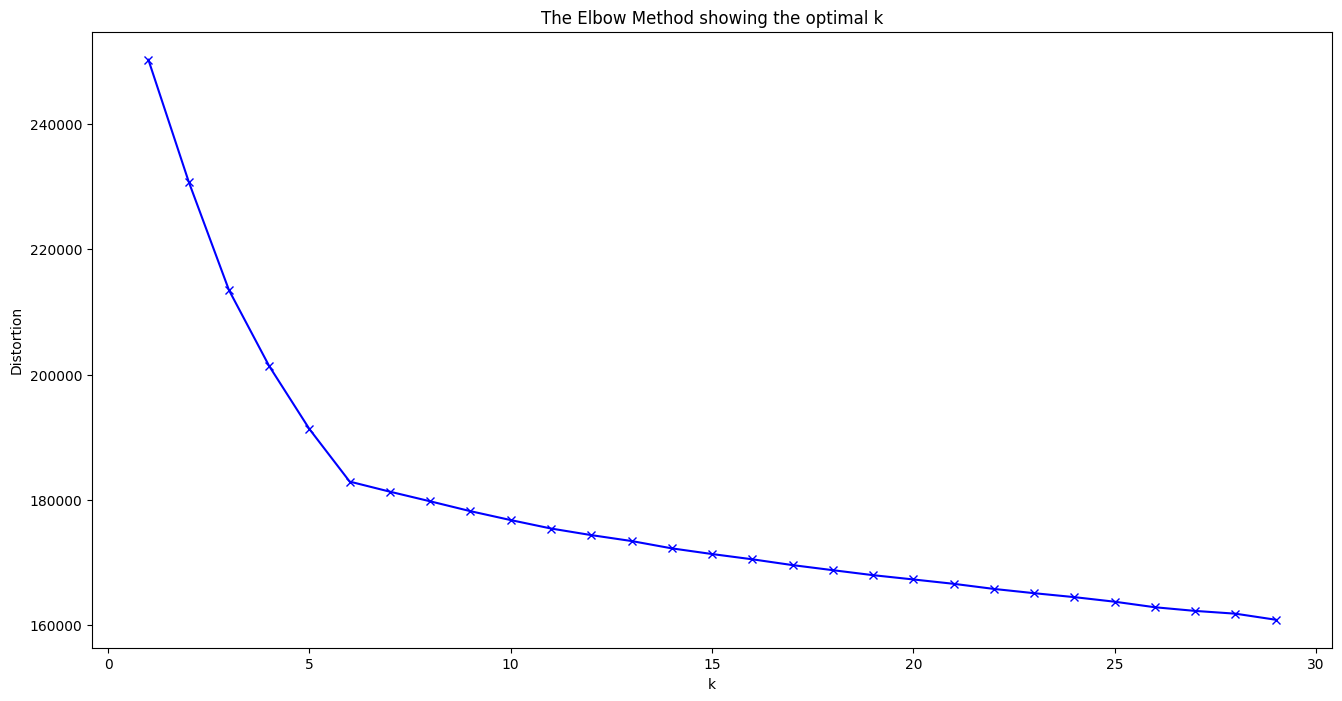

In [ ]:
distortions = []
K = range(1,30)
for k in K:
    kmeanModel =  KMeans(n_clusters=k, init= 'k-means++',n_init= 20, max_iter= 500 , random_state=1)
    kmeanModel.fit(vectors)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [17]:
kmeans_model = KMeans(n_clusters=6, init='random',n_init=10, max_iter=100)
kmeans_model.fit(vectors)
kmean_labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_

In [32]:
best_dbscan_model = None
best_dbscan_homogeneity = -np.inf

k = 0
for eps in np.arange(0.25, .75, 0.005):
    for min_samples in range(5, 7):
        dbscan_model = DBSCAN(eps=eps, min_samples= min_samples, metric='cosine')
        dbscan_labels = dbscan_model.fit_predict(vectors)
        if len(set(dbscan_labels)) == 1:
            continue
        k+=1
        dbscan_homogeneity = homogeneity_score(true_labels, dbscan_labels)
        dbscan_silhouette = silhouette_score(vectors, dbscan_labels)
        if dbscan_homogeneity > best_dbscan_homogeneity:
            best_dbscan_homogeneity = dbscan_homogeneity
            best_dbscan_model = dbscan_model
            print(f"DBSCAN Homogeneity with eps = {eps:.3f}        :   {dbscan_homogeneity:.3f}")
            print(f"DBSCAN Silhouette Score with eps = {eps:.3f}   :   {dbscan_silhouette:.3f}")
            print('----------------------------------------------------------')
            k-=1
        if k >= 20:
            break
    if k >= 20:
        break

dbscan_labels = best_dbscan_model.fit_predict(vectors)

DBSCAN Homogeneity with eps = 0.250        :   0.214
DBSCAN Silhouette Score with eps = 0.250   :   -0.234
----------------------------------------------------------
DBSCAN Homogeneity with eps = 0.255        :   0.245
DBSCAN Silhouette Score with eps = 0.255   :   -0.230
----------------------------------------------------------
DBSCAN Homogeneity with eps = 0.260        :   0.274
DBSCAN Silhouette Score with eps = 0.260   :   -0.225
----------------------------------------------------------
DBSCAN Homogeneity with eps = 0.265        :   0.301
DBSCAN Silhouette Score with eps = 0.265   :   -0.220
----------------------------------------------------------
DBSCAN Homogeneity with eps = 0.270        :   0.334
DBSCAN Silhouette Score with eps = 0.270   :   -0.215
----------------------------------------------------------
DBSCAN Homogeneity with eps = 0.275        :   0.368
DBSCAN Silhouette Score with eps = 0.275   :   -0.208
----------------------------------------------------------
DBSC

In [33]:
kmeans_homogeneity = homogeneity_score(true_labels, kmean_labels)
kmeans_silhouette = silhouette_score(vectors, kmean_labels)
print(f"KMeans Homogeneity: {kmeans_homogeneity}")
print(f"KMeans Silhouette Score: {kmeans_silhouette}")

dbscan_homogeneity = homogeneity_score(true_labels, dbscan_labels)
print(f"DBSCAN Homogeneity: {dbscan_homogeneity}")
dbscan_silhouette = silhouette_score(vectors, dbscan_labels)
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")


KMeans Homogeneity: 0.8780663999676785
KMeans Silhouette Score: 0.07749520987272263
DBSCAN Homogeneity: 0.5346645993976673
DBSCAN Silhouette Score: -0.007374233566224575


## **PCA**

7. **How does PCA work?**

Principal Component Analysis (PCA) is a method used to simplify large data sets. It changes a big set of variables into a smaller one, while keeping most of the information from the big set. Here's an easier way to understand how PCA works:

1. **Standardization:** This step makes sure all the initial variables contribute equally to the analysis.

2. **Covariance Matrix Computation:** This step finds connections between different variables in the dataset.

3. **Eigenvectors and Eigenvalues Calculation:** These are figured out from the covariance matrix to find the main components. Eigenvectors show directions in the feature space, while eigenvalues show the size for each direction.

4. **Formation of a Feature Vector:** This step chooses which main components to keep based on the eigenvalues. The components with the biggest eigenvalues capture the most differences.

5. **Data Recasting:** The original data is reshaped along the main components axes, effectively making its dimensionality smaller.


In [34]:
def plot_clusters(vectors, labels, centers=None, title='Clustering'):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 7))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')

    if centers is not None:
        centers_pca = pca.transform(centers)
        plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='x')

    plt.title(title)
    plt.show()

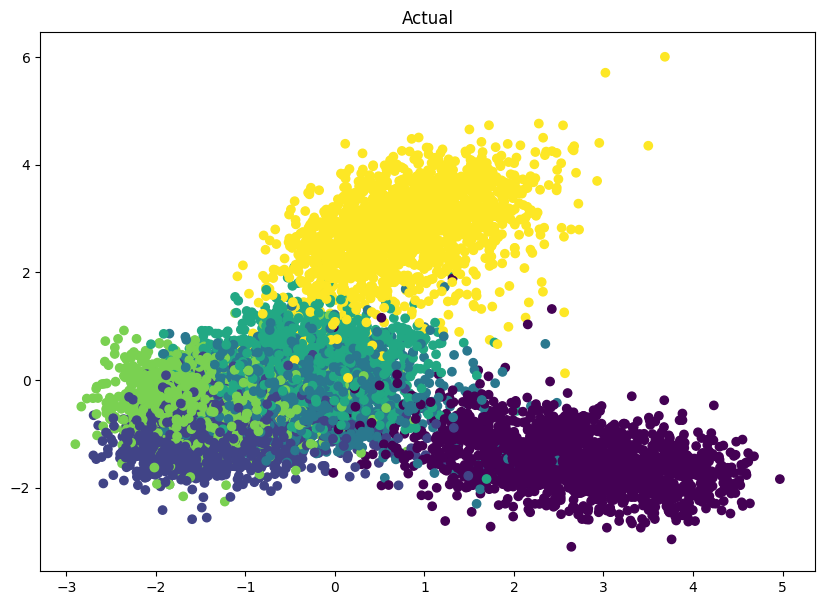

In [45]:
plot_clusters(vectors, true_labels, title='Actual')

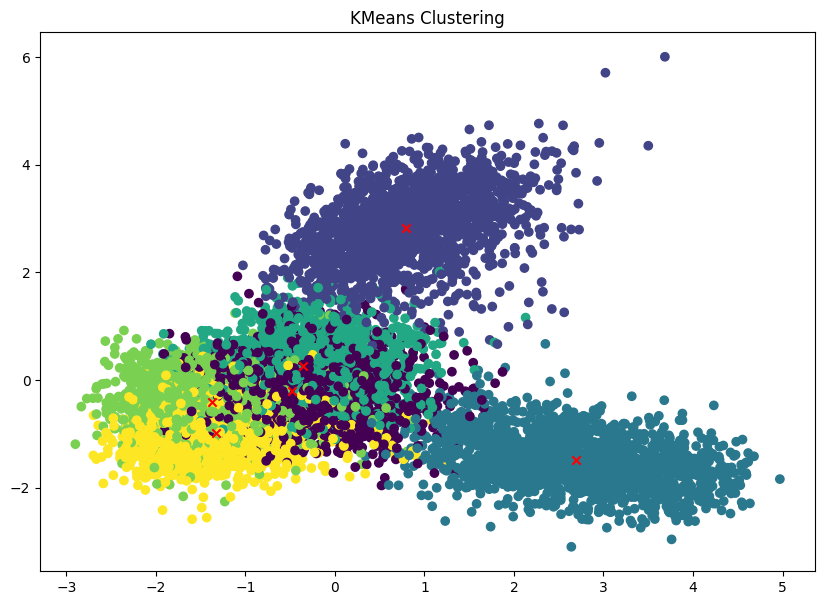

In [36]:
plot_clusters(vectors, kmean_labels, centers=centers, title='KMeans Clustering')

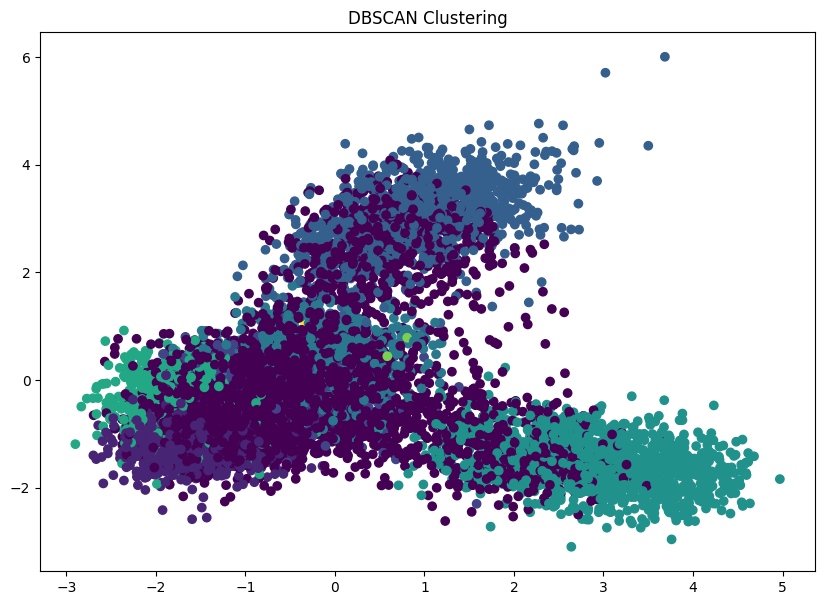

In [37]:
plot_clusters(vectors, dbscan_labels, title='DBSCAN Clustering')

6. **analysis of the performance of the KMeans and DBSCAN**

*KMeans Clustering:*

Homogeneity Score: The homogeneity score for KMeans is approximately `0.878`. This score is close to 1, which indicates that the clusters created by KMeans are highly homogeneous, meaning that each cluster contains predominantly members of a single class.
Silhouette Score: The silhouette score for KMeans is approximately `0.077`. This score is close to 0, suggesting that the clusters are not well-separated and might be too close to each other. A higher silhouette score indicates better-defined and separated clusters.

*DBSCAN Clustering:*

Homogeneity Score: The homogeneity score for DBSCAN is approximately `0.534`. This score is more than half, indicating a moderate level of homogeneity in the clusters. However, it’s less effective at creating pure clusters compared to KMeans.
Silhouette Score: The silhouette score for DBSCAN is approximately `-0.0087`. This negative score indicates that the clusters might be overlapping, and points might have been assigned to the wrong clusters.

These results are also observable considering what we have shown above.

8. **Silhouette Score & Homogeneity**


    1. **Silhouette Coefficient**:

    This metric gives a measure of how similar an object is to its own cluster compared to other clusters. The value ranges from -1 to 1. A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

    $$s = \frac{b - a}{\max(a, b)}$$

    - (a) is the mean intra-cluster distance (the average distance between the current sample and all other points in the same cluster).
    - (b) is the mean nearest-cluster distance (the average distance between the current sample and all samples in the nearest non-identical cluster).



    2. **Homogeneity**: This metric measures whether each cluster contains only members of a single class or not. Its value ranges from 0 to 1, where 1 stands for perfectly homogeneous labeling. In other words, a cluster is homogeneous if all of its elements belong to the same class. This metric is useful when the ground truth labels are known.

    If (C) is a ground truth class assignment and (K) the clustering, we can define homogeneity as:
    $$h = 1 - \frac{H(C|K)}{H(C)}$$

    where (H(C|K)) is the conditional entropy of the ground truth class assignments given the cluster assignments, and (H(C)) is the entropy of the ground truth class assignments. A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.



    *Note:*  you can have high homogeneity but a low silhouette score when the clusters are well separated in terms of classes (high homogeneity), but the data points within each cluster are not tightly grouped or are close to data points in other clusters (low silhouette). This might indicate that while the clustering algorithm is doing a good job of separating different classes, the boundaries between clusters may not be well defined, or there might be too many or too few clusters.

9.

In [ ]:
kmeans_homogeneity = homogeneity_score(true_labels, kmean_labels)
kmeans_silhouette = silhouette_score(vectors, kmean_labels)
print(f"KMeans Homogeneity: {kmeans_homogeneity}")
print(f"KMeans Silhouette Score: {kmeans_silhouette}")

dbscan_homogeneity = homogeneity_score(true_labels, dbscan_labels)
print(f"DBSCAN Homogeneity: {dbscan_homogeneity}")
dbscan_silhouette = silhouette_score(vectors, dbscan_labels)
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")


KMeans Homogeneity: 0.8780663999676785
KMeans Silhouette Score: 0.07749520987272263
DBSCAN Homogeneity: 0.5346645993976673
DBSCAN Silhouette Score: -0.007374233566224575


10. **Improve Performance of Model**

To improve the performance of the models in Kmeans and DBScan, we could modify the parameters of each model to reach better metrics.

The most significant effect is related to the preprocessing of the dataset which I saw the result of it in my project.